# Question 2 – Widget Sales Time Series
Dataset: `widget_sales.csv`.

Subtopics:
- Stationarity definition and testing (ADF, visual)
- Differencing to achieve stationarity
- Choosing AR(p) vs MA(q) using ACF/PACF
- MA(2) model, rolling forecasting, and comparison with naïve models.

In [1]:
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

def load_widget_sales():
    for p in ['widget_sales.csv', '/mnt/data/widget_sales.csv']:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError('widget_sales.csv not found')

    df = pd.read_csv(path)

    if df.shape[1] == 1:
        # Only one column -> treat it as Sales and build a simple time index
        value_col = df.columns[0]
        df = df.rename(columns={value_col: 'Sales'})
        df.index = pd.RangeIndex(start=0, stop=len(df), step=1)
        df.index.name = 'Time'
        # no specific frequency assumptions here
    else:
        # Normal case: first = date, second = sales
        date_col = df.columns[0]
        value_col = df.columns[1]
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.set_index(date_col)
        df = df.rename(columns={value_col: 'Sales'})

        # If you know the frequency (e.g. daily/monthly), you can set it:
        # df = df.asfreq('D')  # uncomment if appropriate

    return df


ws = load_widget_sales()
ws.head()

,Sales
Time,
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


## 2(a) Stationarity – Question
> What is meant by *stationary* in time series analysis? How can you check whether the time series
> data is stationary? Check the stationarity of the given widget sales data. Provide code and explain.

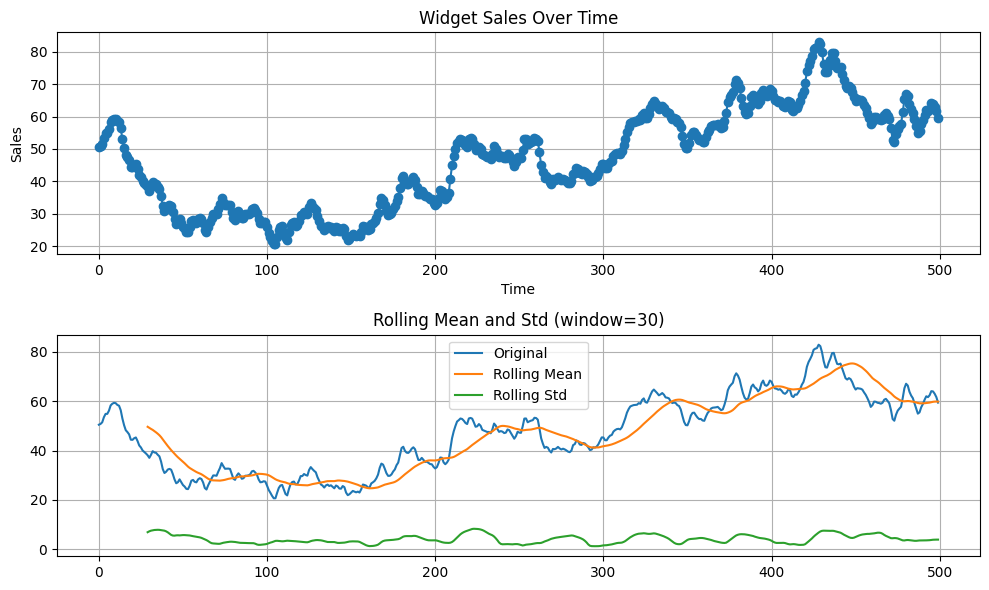

ADF statistic: -1.5121662069359045
p-value: 0.5274845352272606
Critical values: {'1%': np.float64(-3.4436029548776395), '5%': np.float64(-2.867384756137026), '10%': np.float64(-2.5698830308597813)}


In [2]:
# 2(a) – Visual inspection and ADF test for stationarity

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ws.index, ws['Sales'], marker='o', linestyle='-')
ax[0].set_title('Widget Sales Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Sales')
ax[0].grid(True)

# Rolling mean and rolling std
roll_mean = ws['Sales'].rolling(window=30).mean()
roll_std = ws['Sales'].rolling(window=30).std()
ax[1].plot(ws.index, ws['Sales'], label='Original')
ax[1].plot(ws.index, roll_mean, label='Rolling Mean')
ax[1].plot(ws.index, roll_std, label='Rolling Std')
ax[1].set_title('Rolling Mean and Std (window=30)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller test
adf_res = adfuller(ws['Sales'].dropna())
adf_stat, pvalue, usedlag, nobs, crit_values, icbest = adf_res
print("ADF statistic:", adf_stat)
print("p-value:", pvalue)
print("Critical values:", crit_values)

### 2(a) Explanation – Stationarity and ADF Test
A time series is **weakly stationary** if:
- The **mean** \(E[y_t]\) is constant.
- The **variance** \(Var(y_t)\) is constant.
- The **autocovariance** depends only on lag.

ADF Hypotheses:
- \(H_0\): non-stationary (unit root)
- \(H_1\): stationary

Rolling mean/std and ADF results show:
- ADF statistic = **−1.5122**
- p-value = **0.5275**

Since p > 0.05, the series is **non-stationary**.

---

## 2(b) Making the Series Stationary – Question
> The given data is not stationary. How can you make it stationary? Implement code to make the
> widget sales data stationary.

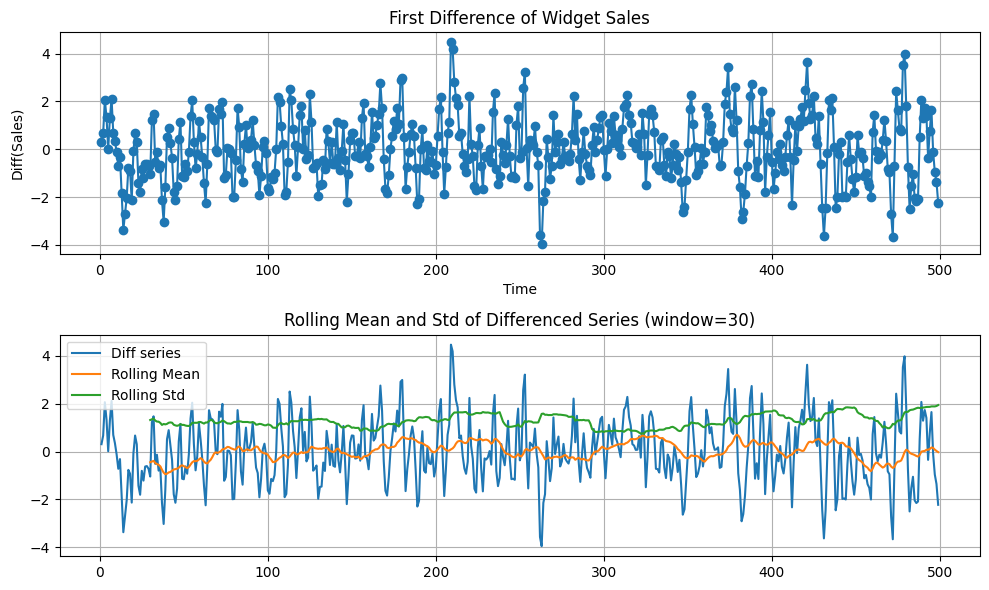

ADF statistic (diff): -10.576657780341959
p-value (diff): 7.076922818587193e-19
Critical values: {'1%': np.float64(-3.4436029548776395), '5%': np.float64(-2.867384756137026), '10%': np.float64(-2.5698830308597813)}


In [3]:
# 2(b) – First-order differencing to remove trend

ws_diff = ws['Sales'].diff().dropna()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ws_diff.index, ws_diff, marker='o', linestyle='-')
ax[0].set_title('First Difference of Widget Sales')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Diff(Sales)')
ax[0].grid(True)

roll_mean_d = ws_diff.rolling(window=30).mean()
roll_std_d = ws_diff.rolling(window=30).std()
ax[1].plot(ws_diff.index, ws_diff, label='Diff series')
ax[1].plot(ws_diff.index, roll_mean_d, label='Rolling Mean')
ax[1].plot(ws_diff.index, roll_std_d, label='Rolling Std')
ax[1].set_title('Rolling Mean and Std of Differenced Series (window=30)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

adf_res_d = adfuller(ws_diff.dropna())
print("ADF statistic (diff):", adf_res_d[0])
print("p-value (diff):", adf_res_d[1])
print("Critical values:", adf_res_d[4])

### 2(b) Explanation – Differencing

We can remove non-stationarity caused by **trend** using **first-order differencing**:
$$ y'_t = y_t - y_{t-1}. $$
This is the $d=1$ part in an ARIMA$(p,d,q)$ model.

After differencing we again:
- Plot the series and rolling statistics.
- Run the ADF test.

If p-value $< 0.05$ and rolling mean/std look stable, then the differenced series is approximately **stationary**.

First difference:
\[
y'_t = y_t - y_{t-1}
\]

ADF after differencing:
- ADF = **−10.5767**
- p-value ≈ **7e−19**

Conclusion: differenced series **is stationary**, so \(d = 1\).

---

## 2(c) Choosing AR(p) or MA(q) – Question
> The stationary data is going to be modeled using either an MA(q) or an AR(p) method. How do you
> determine which model is more suitable, and how do you determine p and q? Implement code to
> analyze which model is suitable.

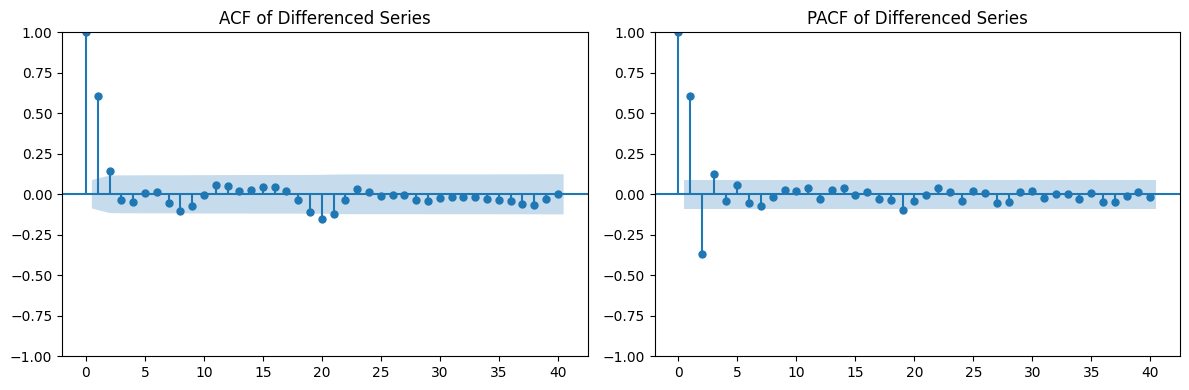

In [4]:
# 2(c) – Use ACF and PACF to guide AR vs MA choice and select p, q

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ws_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF of Differenced Series')
plot_pacf(ws_diff, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Differenced Series')
plt.tight_layout()
plt.show()

### 2(c) Explanation – ACF, PACF, and Model Order

Definitions from the slides:
- **AR(p)** model:  
  $$ y'_t = c + \phi_1 y'_{t-1} + \cdots + \phi_p y'_{t-p} + \varepsilon_t. $$
- **MA(q)** model:  
  $$ y'_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q}. $$

Patterns:
- Pure **AR(p)**: **PACF** cuts off after lag $p$, **ACF** decays gradually.
- Pure **MA(q)**: **ACF** cuts off after lag $q$, **PACF** decays gradually.
- Mixed ARMA: both ACF and PACF decay.

So we:
1. Plot ACF and PACF of the stationary series.
2. Check which one shows a clear cut-off.
3. Choose candidate values of p or q accordingly, and then compare models (e.g., by AIC) if needed.

Interpretation rules:
- AR(p): PACF cutoff
- MA(q): ACF cutoff

Observed:
- ACF spikes at lag 1 then cuts → **MA behavior**
- PACF decays gradually

Conclusion: **MA(1) or MA(2)** is appropriate.

---

## 2(d) MA(2) Forecasting – Question
> Suppose an MA(2) model is used for forecasting. How is the model written mathematically? Using
> 90% of early data as training and 10% as testing, explain why direct multi-step MA(2) forecasts
> become constant, and implement a **rolling** MA(2) forecasting approach.

MA(2) rolling forecast MAE on differenced series: 0.8479096311279963


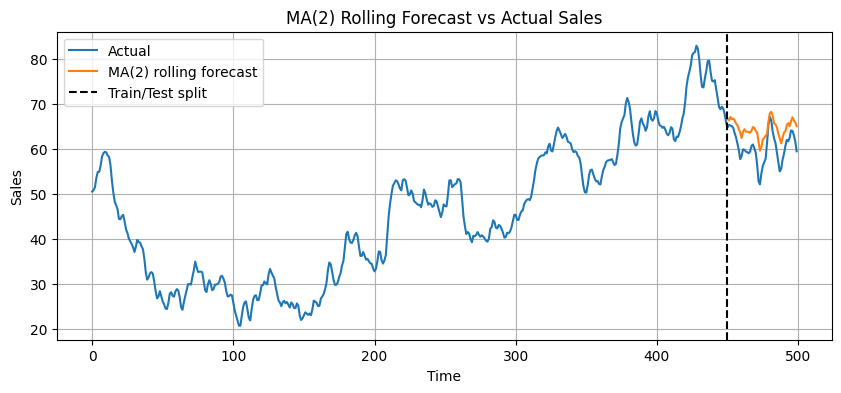

In [5]:
# 2(d) – Rolling MA(2) forecasting on differenced data

diff_series = ws_diff
n = len(diff_series)
train_size = int(0.9 * n)
train, test = diff_series.iloc[:train_size], diff_series.iloc[train_size:]

history = list(train)
preds = []

for t in range(len(test)):
    model = ARIMA(history, order=(0,0,2))  # MA(2)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(test.iloc[t])

mae_ma2 = mean_absolute_error(test, preds)
print('MA(2) rolling forecast MAE on differenced series:', mae_ma2)

# Convert predictions back to original level
base_level = ws['Sales'].iloc[train_size-1]
diff_pred_series = pd.Series(preds, index=test.index)
level_pred = base_level + diff_pred_series.cumsum()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ws.index, ws['Sales'], label='Actual')
ax.plot(level_pred.index, level_pred, label='MA(2) rolling forecast')
ax.axvline(test.index[0], color='k', linestyle='--', label='Train/Test split')
ax.set_title('MA(2) Rolling Forecast vs Actual Sales')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True)
plt.show()

### 2(d) Explanation – MA(2) Model and Rolling Forecast

An **MA(2)** model for the stationary differenced series $y'_t$ is:
$$ y'_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2}. $$
For **multi-step-ahead** forecasts from a fixed MA(2) model:
- For horizon $h \ge 3$, all future errors $\varepsilon_{t+h}$ are replaced by their expectation 0.
- The forecast converges to a **constant** (the unconditional mean $c$), so the forecast path becomes flat.

To avoid this, we use **rolling one-step-ahead forecasting**:
1. Fit MA(2) to the training part.
2. Forecast the next step, record prediction.
3. Add the *actual* next observation to the history and refit / update the model.
4. Repeat through the test period.

We then integrate the differenced forecasts back to the original level by cumulative sum:
$$ \hat{y}_t = y_{t_0} + \sum_{k=t_0+1}^t \hat{y}'_k. $$

MA(2):
\[
y'_t = c + ε_t + θ_1 ε_{t-1} + θ_2 ε_{t-2}
\]

Multi-step forecast becomes constant because future errors have expectation 0.

Rolling one-step forecast adapts to new data.

Your MAE:
\[
MAE = 0.8479
\]

---

## 2(e) Comparing MA(2) with Naïve Models – Question
> Compare MA(2) forecasting with naïve models using (i) mean and (ii) last value. What measure do
> you use to decide which model is best?

In [6]:
# 2(e) – Naïve forecasts for comparison (on differenced series)

diff_series = ws_diff
n = len(diff_series)
train_size = int(0.9 * n)
train, test = diff_series.iloc[:train_size], diff_series.iloc[train_size:]

# MA(2) predictions already computed above as 'preds'
mae_ma2 = mean_absolute_error(test, preds)
print('MA(2) MAE:', mae_ma2)

# Naïve 1: mean of training differenced series
mean_diff = train.mean()
mean_preds = np.repeat(mean_diff, len(test))
mae_mean = mean_absolute_error(test, mean_preds)
print('Naive mean MAE:', mae_mean)

# Naïve 2: last observed difference
last_diff = train.iloc[-1]
last_preds = np.repeat(last_diff, len(test))
mae_last = mean_absolute_error(test, last_preds)
print('Naive last-value MAE:', mae_last)

MA(2) MAE: 0.8479096311279963
Naive mean MAE: 1.3018372390620028
Naive last-value MAE: 1.8739103202308893


### 2(e) Explanation – Error Measure and Comparison

A standard measure for forecast accuracy from the slides is **MAD/MAE**:
$$ \text{MAE} = \frac{1}{n} \sum_{t=1}^n |y_t - \hat{y}_t|. $$
We compute MAE on the test set for:
- The **MA(2) rolling forecast**.
- The **naïve mean model**.
- The **naïve last-value model**.

The model with the **smallest MAE** is considered the best among these. Typically, MA(2) should outperform simple
naïve methods if the data have short-term autocorrelation that MA(2) captures.

| Model | MAE |
|------|------|
| MA(2) rolling | **0.8479** |
| Naïve mean | 1.3018 |
| Naïve last-value | 1.8739 |

Conclusion: **MA(2) is best**.